In [32]:
import spikeinterface.full as si
from spikeinterface.curation import load_curation, apply_curation
from spikeinterface.sorters import get_default_sorter_params, get_sorter_params_description
import probeinterface as pi
from spikeinterface_gui import run_mainwindow
import woodsort.helper_functions as hf 
import matplotlib.pyplot as plt
import json
import platform
import subprocess
import re
from pathlib import Path
import numpy as np
from scipy.signal import firwin, fftconvolve
from tqdm import tqdm
import pynapple as nap


In [3]:
# Spike sorting pipeline for the H7100 dataset
# Experimenter: Trisha Narayanan 
# Acquired: Dec 2024 - May 2025

#paths
#recfolder_path ='/home/avadher/SIDB_Datastore/Trisha/Raw/H7100/H7113/H7113-250604'
recfolder_path = '/home/avadher/Data/H7113-250604/'

# parameters for probe
shank_groups = [0, 1] # specify which groups in the xml file are shanks to be sorted (0-base)
probe_manufacturer = "cambridgeneurotech"
probe_name = "ASSY-156-H7" 

# parameters for spike sorting
sorter = "mountainsort5"

# parameters for tracking 
ttl_channel = 64 # channel in DAT file where camera TTL pulses are registered (0-base)
column_names=['x_left','y_left','x_right','y_right']  # keep the same names but change order as recorded
pixel_width = 0.1  # size of one pixel in cm 
min_spacing = 3  # minimum spacing between two LEDs in cm 
max_spacing = 6  # maximum spacing between two LEDs in cm 

# paths 
recfolder_path = Path(recfolder_path)
session_name = recfolder_path.name
processed_folder_name = 'Processed'
spikesorting_folder_name = f"{session_name}_sorting_{sorter}"
spikesorting_path =recfolder_path / spikesorting_folder_name
analyzer_folder_name = f"{session_name}_analyzer_{sorter}"
analyzer_path = recfolder_path / analyzer_folder_name
curation_path = analyzer_path / 'curation.json'



Extracting epoch timestamps...

Extracting start and end times: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1

Extracting start and end times: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording2

Extracting start and end times: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording3

Epoch timestamps saved to: /home/avadher/Data/H7113-250604/EpochTimestamps.csv


Aligning Bonsai tracking data...


Recording path: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1
TTL pulses:         25592
Bonsai frames:      25591
Trimming 1 extra TTL pulses at the end

Recording path: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording2
TTL pulses:         216494
Bonsai frames:      216480
Trimming 14 extra TTL pulses at the end

Recording path: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Nod

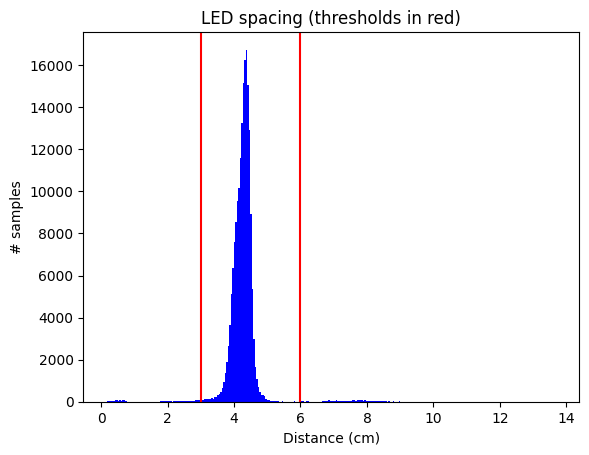

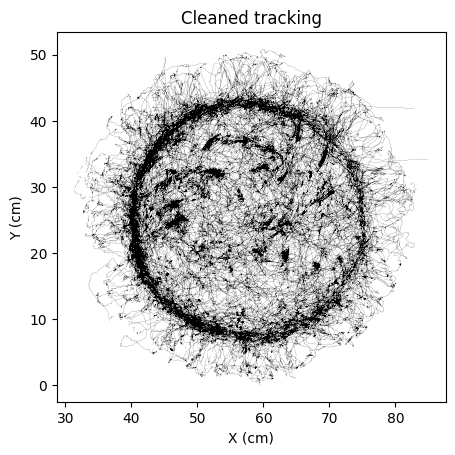

In [3]:
# align and process tracking

# get epochs
epochs = hf.get_epochs_openephys(
    recfolder_path, 
    save_path =recfolder_path)

# align tracking
aligned_tracking = hf.align_tracking_bonsai(
    recfolder_path=recfolder_path, 
    ttl_channel=ttl_channel, 
    column_names=column_names, 
    save_path=recfolder_path)

# process tracking
processed_tracking = hf.process_tracking_bonsai(
        aligned_tracking,   
        pixel_width=pixel_width,      # conversion factor: cm per pixel
        min_spacing=min_spacing,      # minimum allowed LED spacing (cm)
        max_spacing=max_spacing,  
        save_path=recfolder_path,  # maximum allowed LED spacing (cm)
        plot=True)             # whether to show diagnostic plot


In [29]:



def process_lfp_from_dat(
    dat_file,
    output_folder,
    lfp_name,
    input_sample_rate,
    num_channels,
    output_sample_rate=1250,
    lopass=450,
    chunk_size=100_000,
    max_filter_taps=2000
):
    dat_file = Path(dat_file)
    if not dat_file.exists():
        raise FileNotFoundError(f"DAT file not found: {dat_file}")
    if dat_file.name != "continuous.dat":
        raise ValueError(f"Expected a file named 'continuous.dat', got: {dat_file.name}")

    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    lfp_file = output_folder / f"{lfp_name}.lfp"

    downsample_ratio = int(input_sample_rate / output_sample_rate)

    signal = nap.load_eeg(
        str(dat_file),
        n_channels=num_channels,
        frequency=input_sample_rate,
        channel=None
    )
    total_samples = signal.shape[0]

    # Filter setup (centred FIR)
    ntbuff = int(np.round((4 * input_sample_rate) / lopass))
    ntbuff += (downsample_ratio - ntbuff % downsample_ratio) % downsample_ratio
    ntbuff = min(ntbuff, max_filter_taps)
    fir_coeff = firwin(ntbuff, lopass / (input_sample_rate / 2))

    # Align chunk size to downsample grid
    chunk_size += (downsample_ratio - chunk_size % downsample_ratio) % downsample_ratio
    nb_full_chunks = total_samples // chunk_size
    remainder = total_samples % chunk_size

    with lfp_file.open("wb") as flfp:

        # -------- FULL CHUNKS --------
        for ibatch in tqdm(range(nb_full_chunks), desc="Processing LFP"):
            chunk_raw_start = ibatch * chunk_size
            chunk_raw_end   = (ibatch + 1) * chunk_size

            window_start = max(0, chunk_raw_start - ntbuff)
            window_end   = min(total_samples, chunk_raw_end + ntbuff)

            dat = signal[window_start:window_end, :].astype(np.float64)

            ds_chunk_size = chunk_size // downsample_ratio
            # Global raw indices we want in the output for this chunk
            raw_idx = chunk_raw_start + np.arange(ds_chunk_size) * downsample_ratio
            local_idx = raw_idx - window_start  # indices into `dat` / `filtered`

            lfp_data = np.zeros((num_channels, ds_chunk_size), dtype=np.int16)

            for ch in range(num_channels):
                filtered = fftconvolve(dat[:, ch], fir_coeff, mode="same")

                # Safety: ensure indices are in-bounds
                if local_idx[-1] >= filtered.shape[0] or local_idx[0] < 0:
                    raise RuntimeError(
                        f"Indexing out of bounds in chunk {ibatch}: "
                        f"local_idx range {local_idx[0]}..{local_idx[-1]} "
                        f"but filtered len {filtered.shape[0]}"
                    )

                lfp_data[ch, :] = filtered[local_idx].astype(np.int16)

            flfp.write(lfp_data.T.tobytes())

        # -------- REMAINDER --------
        if remainder > 0:
            rem_start = nb_full_chunks * chunk_size
            true_ds = remainder // downsample_ratio

            # Window: include left buffer so convolution is valid at rem_start
            window_start = max(0, rem_start - ntbuff)
            window_end   = total_samples

            dat = signal[window_start:window_end, :].astype(np.float64)

            # Global raw indices we want in the remainder output
            raw_idx = rem_start + np.arange(true_ds) * downsample_ratio
            local_idx = raw_idx - window_start

            lfp_data = np.zeros((num_channels, true_ds), dtype=np.int16)

            for ch in range(num_channels):
                filtered = fftconvolve(dat[:, ch], fir_coeff, mode="same")

                if true_ds > 0:
                    if local_idx[-1] >= filtered.shape[0] or local_idx[0] < 0:
                        raise RuntimeError(
                            "Indexing out of bounds in remainder: "
                            f"local_idx range {local_idx[0]}..{local_idx[-1]} "
                            f"but filtered len {filtered.shape[0]}"
                        )

                    lfp_data[ch, :] = filtered[local_idx].astype(np.int16)

            flfp.write(lfp_data.T.tobytes())


def batch_process_lfp(
    session_folder,
    output_sample_rate=1250,
    lopass=450,
    chunk_size=100_000,
):
    """
    Find all recording* folders under session_folder. For each recording folder:
      - read structure.oebin in that folder
      - find continuous.dat somewhere underneath
      - process it into session_folder/local_field_potential_X.lfp
    """

    session_folder = Path(session_folder)
    session_folder.mkdir(parents=True, exist_ok=True)

    # Find recording* directories anywhere under the session folder
    recording_folders = sorted(
        [p for p in session_folder.rglob("recording*") if p.is_dir()],
        key=lambda p: (len(p.parts), p.name),
    )

    if not recording_folders:
        print(f"No recording* folders found under {session_folder}")
        return

    idx = 0
    for rec in recording_folders:
        oebin_path = rec / "structure.oebin"
        if not oebin_path.exists():
            # not a real Open Ephys recording folder (or incomplete)
            continue

        dat_files = sorted(rec.rglob("continuous.dat"))
        if not dat_files:
            print(f"\nSkipping {rec}: no continuous.dat found under it.")
            continue

        if len(dat_files) > 1:
            # pick the one closest to the recording folder (least nested)
            dat_files = sorted(dat_files, key=lambda p: len(p.relative_to(rec).parts))

        dat_file = dat_files[0]

        with oebin_path.open("r") as f:
            oebin = json.load(f)

        try:
            cont0 = oebin["continuous"][0]
            input_sample_rate = cont0["sample_rate"]
            num_channels = cont0["num_channels"]
        except Exception as e:
            raise RuntimeError(f"Could not parse metadata from {oebin_path}: {e}")

        idx += 1
        lfp_name = f"local_field_potential_{idx}"
        out_lfp = session_folder / f"{lfp_name}.lfp"

        print(f"\n[{idx}] recording folder: {rec}")

        process_lfp_from_dat(
            dat_file=dat_file,
            output_folder=session_folder,
            lfp_name=lfp_name,
            input_sample_rate=input_sample_rate,
            num_channels=num_channels,
            output_sample_rate=output_sample_rate,
            lopass=lopass,
            chunk_size=chunk_size,
        )

    print(f"\nDone. Processed {idx} recording folder(s).")

batch_process_lfp(recfolder_path)




[1] recording folder: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1
  DAT: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat
  OEBIN: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1/structure.oebin
  Sample rate: 30000.0, Channels: 72
  Output: /home/avadher/Data/H7113-250604/local_field_potential_1.lfp


Processing LFP: 100%|██████████| 194/194 [00:27<00:00,  7.00it/s]



DAT samples per channel: 19453800
LFP samples per channel: 810575
Equivalent DAT samples (LFP * downsample_ratio): 19453800
Difference: 0 (should be 0)

[2] recording folder: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording2
  DAT: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording2/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat
  OEBIN: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording2/structure.oebin
  Sample rate: 30000.0, Channels: 72
  Output: /home/avadher/Data/H7113-250604/local_field_potential_2.lfp


Processing LFP: 100%|██████████| 1625/1625 [04:33<00:00,  5.95it/s]



DAT samples per channel: 162541800
LFP samples per channel: 6772575
Equivalent DAT samples (LFP * downsample_ratio): 162541800
Difference: 0 (should be 0)

[3] recording folder: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording3
  DAT: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording3/continuous/Acquisition_Board-100.Rhythm Data/continuous.dat
  OEBIN: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording3/structure.oebin
  Sample rate: 30000.0, Channels: 72
  Output: /home/avadher/Data/H7113-250604/local_field_potential_3.lfp


Processing LFP: 100%|██████████| 1274/1274 [02:59<00:00,  7.11it/s]



DAT samples per channel: 127437900
LFP samples per channel: 5309912
Equivalent DAT samples (LFP * downsample_ratio): 127437888
Difference: 12 (should be 0)

Done. Processed 3 recording folder(s).


In [33]:
def merge_lfp(session_folder, output_name="LocalFieldPotential.lfp"):
    session_folder = Path(session_folder)
    out_path = session_folder / output_name

    # Collect files
    files = list(session_folder.glob("local_field_potential_*.lfp"))
    files = [f for f in files if f.name != output_name]
    if not files:
        raise FileNotFoundError(f"No local_field_potential_*.lfp in {session_folder}")

    # Numeric sort by the trailing index X in local_field_potential_X.lfp
    def idx(p: Path):
        m = re.search(r"local_field_potential_(\d+)\.lfp$", p.name)
        return int(m.group(1)) if m else 10**12
    files = sorted(files, key=idx)

    system = platform.system().lower()

    if system.startswith("windows"):
        # copy /B "a" + "b" + "c" "out"
        # Must run under cmd.exe for copy builtin
        parts = ['copy', '/B']
        # Build: "f1" + "f2" + ... + "fn"
        expr = ' + '.join([f'"{str(f)}"' for f in files])
        cmd = f'copy /B {expr} "{str(out_path)}"'
        subprocess.run(["cmd", "/c", cmd], check=True)

    else:
        # unix/mac: cat "f1" "f2" ... > "out"
        # Use shell redirection, but quote safely by passing through /bin/sh -c
        # Build a single command string with quoted paths
        quoted = " ".join([subprocess.list2cmdline([str(f)]) for f in files])
        cmd = f"cat {quoted} > {subprocess.list2cmdline([str(out_path)])}"
        subprocess.run(["/bin/sh", "-c", cmd], check=True)
        
        print(f"\Individual LFP files merged into {output_name}.")

    return 

merge_lfp(recfolder_path)

<>:36: DeprecationWarning: invalid escape sequence '\I'
<>:36: DeprecationWarning: invalid escape sequence '\I'
/tmp/ipykernel_453017/1948857404.py:36: DeprecationWarning: invalid escape sequence '\I'
  print(f"\Individual LFP files merged into {output_name}.")


\Individual LFP files merged into LocalFieldPotential.lfp.


Probe updated with Neuroscope mapping


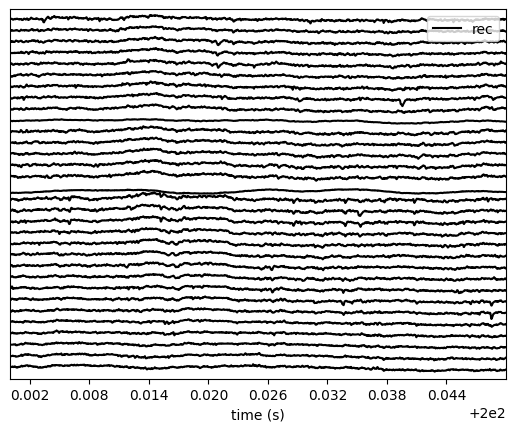

In [5]:
### Load and prepare recording ### 

# Load recording and probe, fill channel indices from Neuroscope
recording = si.read_openephys(recfolder_path,stream_id='0')
# print(pi.list_all_probes()) # list all available probes 
probe = pi.get_probe(manufacturer=probe_manufacturer, probe_name=probe_name)
neuroscope_channel_indices = hf.load_neuroscope_channels(recfolder_path, shank_groups=shank_groups) # load xml file
probe = hf.add_neuroscope_mapping(probe, neuroscope_channel_indices)

# Process recording for spike sorting  
recording = si.concatenate_recordings([recording])
recording = recording.set_probe(probe, group_mode = 'by_shank')
#si.plot_probe_map(recording, with_device_index=True)
recording = recording.split_by('group')

# Check if the trace looks ok 
si.plot_traces(recording[0], order_channel_by_depth=True, time_range=[200,200.05])
plt.show()

# Filter recording
si.set_global_job_kwargs(n_jobs=12) # 
filtered_recording = si.bandpass_filter(recording)
filtered_recording = si.detect_and_remove_bad_channels(filtered_recording)

# Run spike sorting ###
sorting = si.run_sorter(
    recording=filtered_recording, 
    sorter_name=sorter, 
    remove_existing_folder=True, 
    folder=spikesorting_path)


In [11]:
### Run analyzer ###

# can't do parallel processing in analyzer on DataStore for some reason - it creates files with weird permissions
job_kwargs = dict(n_jobs=1, chunk_duration="1s", progress_bar=True)

sorting_analyzer = si.create_sorting_analyzer(
    recording=filtered_recording, 
    sorting=sorting, 
    format="binary_folder", 
    folder=analyzer_path,
    overwrite=True)

compute_dict = {'unit_locations': {},
                          'random_spikes': {},
                          'noise_levels': {},
                          'waveforms': {'ms_before':0.8, 'ms_after':1.2},
                          'templates': {},
                          'spike_amplitudes': {},
                          'spike_locations': {},
                          'correlograms': {},
                          'quality_metrics': {},
                          'template_similarity': {},
                          'principal_components': {},
                          'template_metrics': {'include_multi_channel_metrics': True},
                          }

sorting_analyzer.compute(compute_dict, **job_kwargs)


estimate_sparsity (workers: 12 processes):   0%|          | 0/10315 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/10315 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Fitting PCA:   0%|          | 0/80 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/80 [00:00<?, ?it/s]

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.p

Compute : spike_amplitudes + spike_locations (no parallelization):   0%|          | 0/10315 [00:00<?, ?it/s]

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  inds_confidence90 = np.row_stack(np.where(conf_matrix[:, test_rp_centers_mask] > 0.9))
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  inds_confidence90 = np.row_stack(np.where(conf_matrix[:, test_rp_centers_mask] > 0.9))
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  inds_confidence90 = np.row_stack(np.where(conf_matrix[:, test_rp_centers_mask] > 0.9))
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` 

noise_level (workers: 12 processes):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/80 [00:00<?, ?it/s]

In [8]:
analyzer = si.load_sorting_analyzer(analyzer_path)

if curation_path.exists(): 
    curation = load_curation(curation_path)
    analyzer = apply_curation(analyzer, curation_dict_or_model=curation)
    print('Curation applied')
# check for curation and apply it 

run_mainwindow(analyzer, mode="desktop", curation=True)

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/core/base.py:1123: DeprecationWarning: `recording_list` is deprecated and will be removed in 0.105.0. Please use `recording_list_or_dict` instead.
  extractor = extractor_class(**new_kwargs)
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  inds_confidence90 = np.row_stack(np.where(conf_matrix[:, test_rp_centers_mask] > 0.9))
/h

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Curation applied


In [9]:
# Apply curation and export to pynapple 

units = hf.export_to_pynapple(
    sorting_analyzer_or_sorting=analyzer, 
    attach_unit_metadata=True
)

print(units)

Index    rate      x          y          z        num_spikes    ...
-------  --------  ---------  ---------  -------  ------------  -----
0        7.48989   23.93879   447.43181  1.0      77254         ...
1        2.75701   24.23031   611.94237  1.0      28437         ...
2        6.05345   0.05848    610.84718  1.0      62438         ...
3        4.43252   2.10976    591.7677   1.0618   45719         ...
4        0.94499   -1.72095   191.91471  1.0      9747          ...
5        2.99473   -10.31764  199.32296  4.83738  30889         ...
6        11.34952  -1.2704    753.58114  1.0      117064        ...
...      ...       ...        ...        ...      ...           ...
74       1.32717   232.84144  178.82289  1.21006  13689         ...
75       3.54008   236.69796  177.62936  8.98377  36514         ...
76       2.23968   239.79668  586.03995  1.06508  23101         ...
77       1.49189   195.9344   556.54178  1.0      15388         ...
78       1.8923    212.24701  576.74093  1.0  